Only the following remain:

    Main price chart (candlestick)
    Body-upper pane
    Body-lower pane

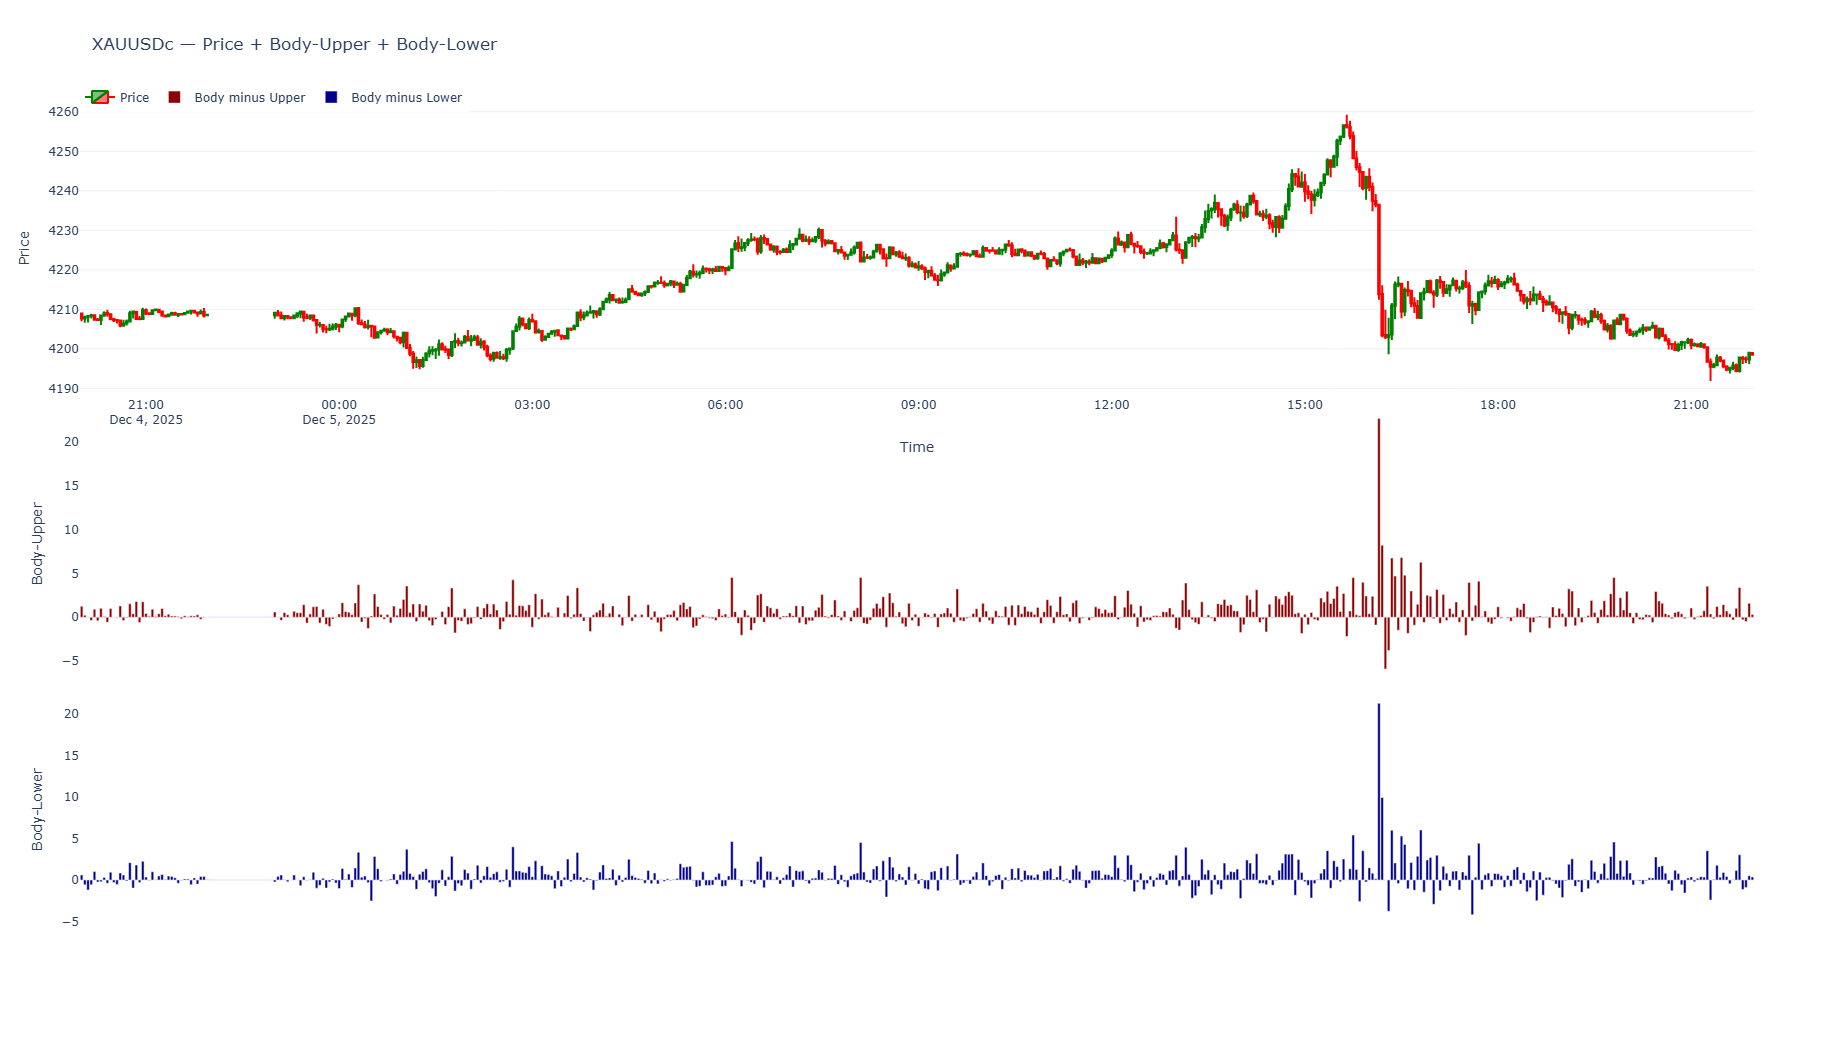

In [1]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df[df.index.dayofweek < 5]

# -------------------------
# Calculations (kept only the ones needed)
# -------------------------
df['body'] = abs(df['close'] - df['open'])
df['upper_wick'] = df['high'] - df[['open','close']].max(axis=1)
df['lower_wick'] = df[['open','close']].min(axis=1) - df['low']

df['body_minus_upper'] = df['body'] - df['upper_wick']
df['body_minus_lower'] = df['body'] - df['lower_wick']

# -------------------------
# Plot: Price + 2 panes
# -------------------------
fig = go.Figure()

# Pane 1 — Price
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='Price',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Pane 2 — Body minus upper wick
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_upper'],
    name='Body minus Upper',
    marker_color='darkred',
    yaxis='y2'
))

# Pane 3 — Body minus lower wick
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_lower'],
    name='Body minus Lower',
    marker_color='darkblue',
    yaxis='y3'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc — Price + Body-Upper + Body-Lower',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price',       domain=[0.66, 1]),
    yaxis2=dict(title='Body-Upper', domain=[0.33, 0.65], showgrid=False),
    yaxis3=dict(title='Body-Lower', domain=[0.05, 0.32], showgrid=False),

    legend=dict(orientation='h', y=1.02, x=0),
    height=1050
)

fig.show()


This pattern score is based on candlestick patterns.

For bearish pattern, give (pattern score = -1) for the corresponding current candle:
Position 0 is a bearish candle.
Position -1 is a bullish candle.
Position -2 is a bullish candle.
The current candle close (position 0) must engulf (lower than) the open price of 'position -1' candle, and the high of 'position -1' is higher than the highs of 'position -2' and 'position 0'. If this condition is met, mark the close price of the current candle.

For bullish pattern, give (pattern score = 1) for the corresponding current candle:
Position 0 is a bullish candle.
Position -1 is a bearish candle.
Position -2 is a bearish candle.
The current candle close (position 0) must engulf (higher than) the open price of 'position -1' candle, and the low of 'position -1' is lower than the lows of 'position -2' and 'position 0'. If this condition is met, mark the close price of the current candle

If the current candle has no corresponding pattern, then assign a pattern score of 0.

Plot these values on separate pane.


The logic implements:

Bearish pattern → score = -1
Bullish pattern → score = +1
Otherwise → score = 0

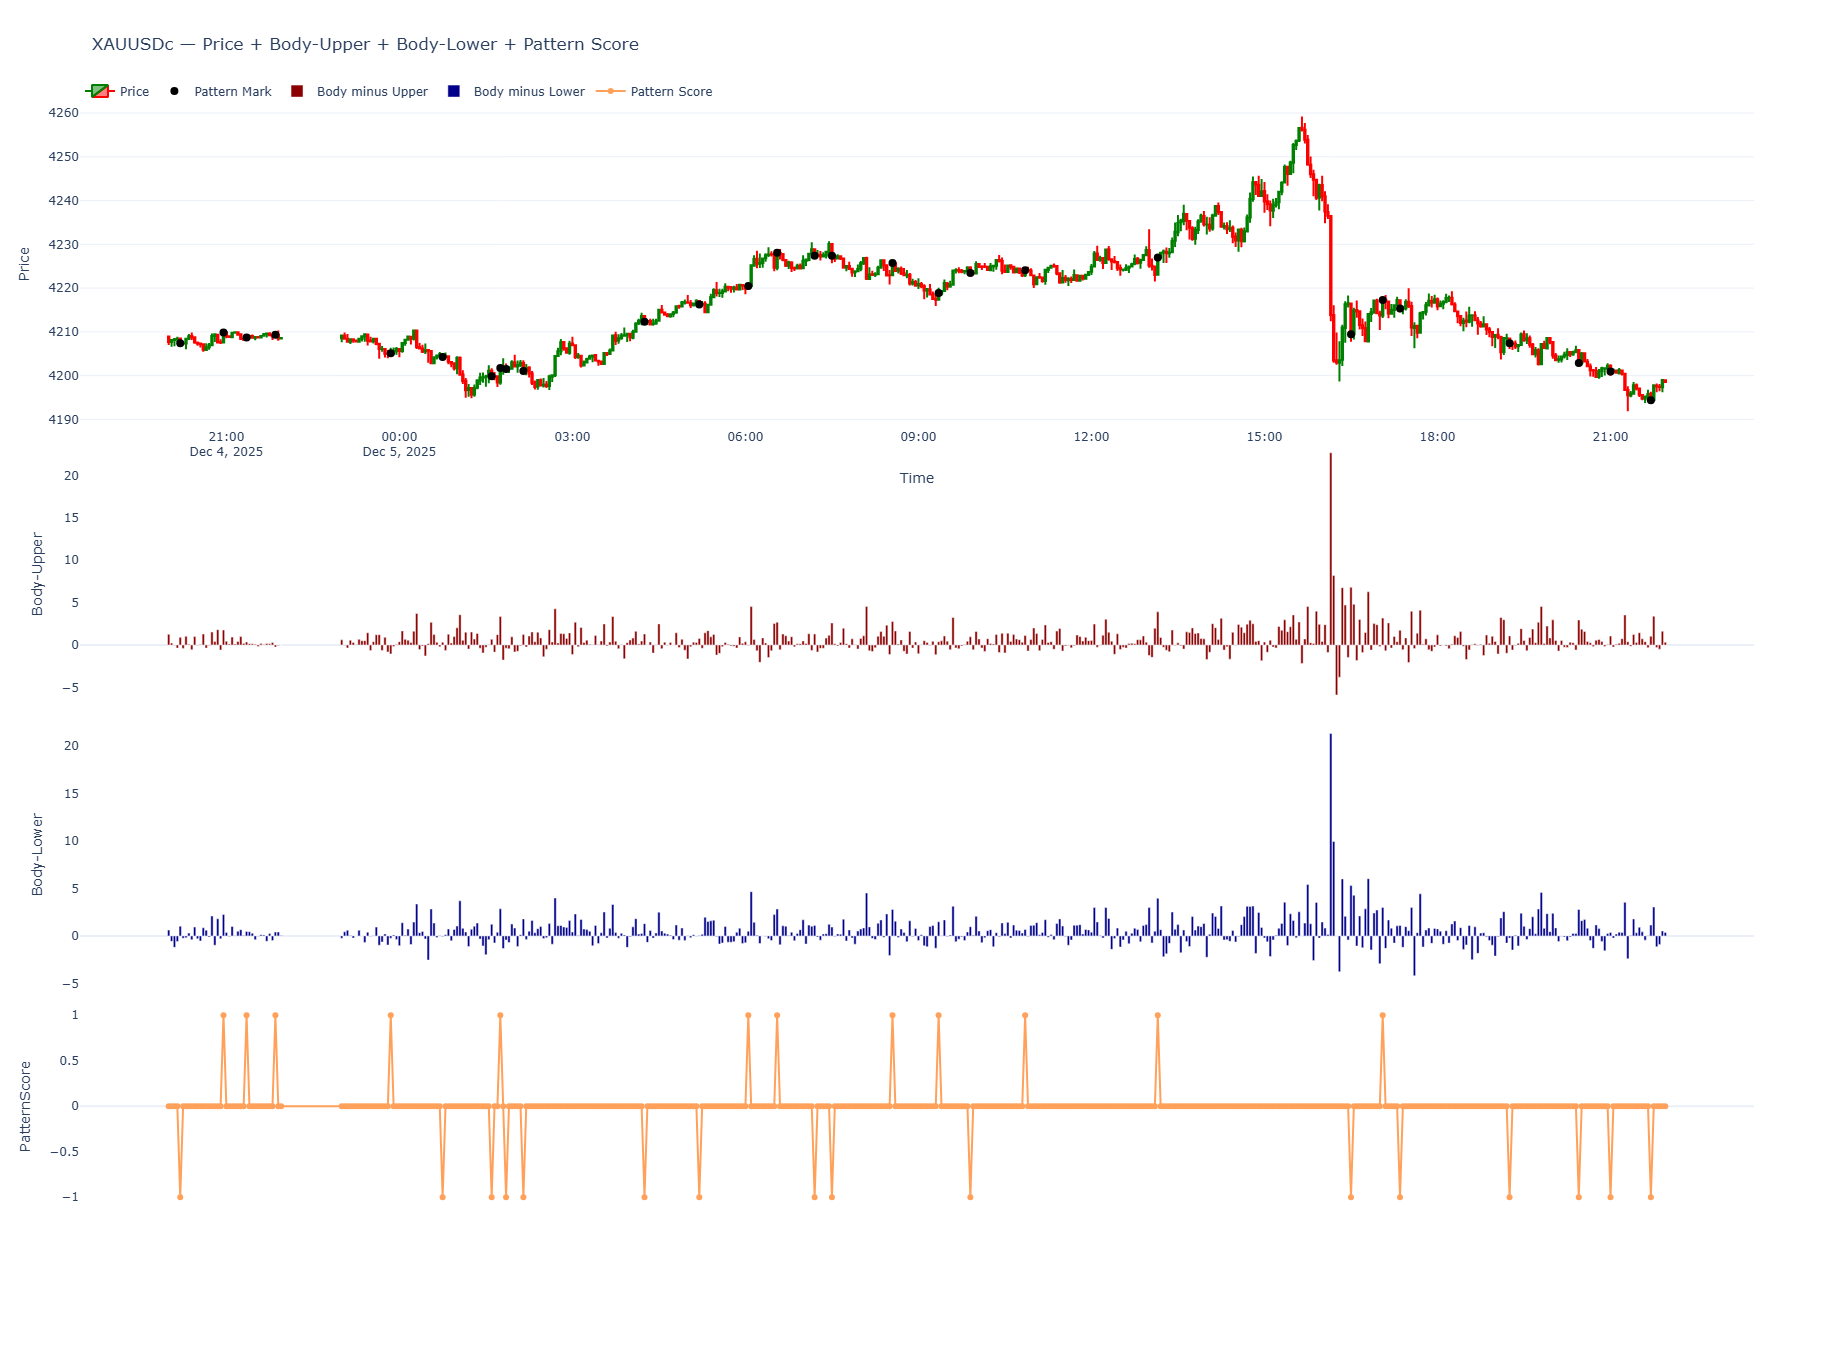

In [2]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df[df.index.dayofweek < 5]

# -------------------------
# Calculations needed
# -------------------------
df['body'] = abs(df['close'] - df['open'])
df['upper_wick'] = df['high'] - df[['open','close']].max(axis=1)
df['lower_wick'] = df[['open','close']].min(axis=1) - df['low']

df['body_minus_upper'] = df['body'] - df['upper_wick']
df['body_minus_lower'] = df['body'] - df['lower_wick']

# -------------------------
# Pattern Score Logic
# -------------------------
pattern_score = []
pattern_mark = []

for i in range(len(df)):
    if i < 2:
        pattern_score.append(0)
        pattern_mark.append(np.nan)
        continue

    # Current (0), previous (-1), and previous (-2)
    o0, h0, l0, c0 = df['open'].iloc[i], df['high'].iloc[i], df['low'].iloc[i], df['close'].iloc[i]
    o1, h1, l1, c1 = df['open'].iloc[i-1], df['high'].iloc[i-1], df['low'].iloc[i-1], df['close'].iloc[i-1]
    o2, h2, l2, c2 = df['open'].iloc[i-2], df['high'].iloc[i-2], df['low'].iloc[i-2], df['close'].iloc[i-2]

    # Current candle directions
    curr_bearish = c0 < o0
    curr_bullish = c0 > o0

    prev_bullish = c1 > o1
    prev_bearish = c1 < o1

    prev2_bullish = c2 > o2
    prev2_bearish = c2 < o2

    score = 0
    mark = np.nan

    # -------------------------
    # Bearish Pattern
    # -------------------------
    if curr_bearish and prev_bullish and prev2_bullish:
        if (c0 < o1) and (h1 > h2) and (h1 > h0):
            score = -1
            mark = c0

    # -------------------------
    # Bullish Pattern
    # -------------------------
    if curr_bullish and prev_bearish and prev2_bearish:
        if (c0 > o1) and (l1 < l2) and (l1 < l0):
            score = 1
            mark = c0

    pattern_score.append(score)
    pattern_mark.append(mark)

df['pattern_score'] = pattern_score
df['pattern_mark'] = pattern_mark

# -------------------------
# Plot: Price + Body-Upper + Body-Lower + Pattern Score
# -------------------------
fig = go.Figure()

# Pane 1 — Price
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='Price',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Pattern Markers on Price Pane
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['pattern_mark'],
    mode='markers',
    marker=dict(size=8, color='black'),
    name='Pattern Mark'
))

# Pane 2 — Body minus upper wick
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_upper'],
    name='Body minus Upper',
    marker_color='darkred',
    yaxis='y2'
))

# Pane 3 — Body minus lower wick
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_lower'],
    name='Body minus Lower',
    marker_color='darkblue',
    yaxis='y3'
))

# Pane 4 — Pattern Score
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['pattern_score'],
    mode='lines+markers',
    name='Pattern Score',
    marker=dict(size=6),
    yaxis='y4'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc — Price + Body-Upper + Body-Lower + Pattern Score',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price',         domain=[0.72, 1]),
    yaxis2=dict(title='Body-Upper',   domain=[0.48, 0.71], showgrid=False),
    yaxis3=dict(title='Body-Lower',   domain=[0.24, 0.47], showgrid=False),
    yaxis4=dict(title='PatternScore', domain=[0.05, 0.23], showgrid=False),

    legend=dict(orientation='h', y=1.02, x=0),
    height=1350
)

fig.show()


The '(Position 0, -1, and -2) candlesticks must have a corresponding at least body-upper or body-lower positive value, otherwise of body-upper or body-lower value is negative then don't mark the signal,

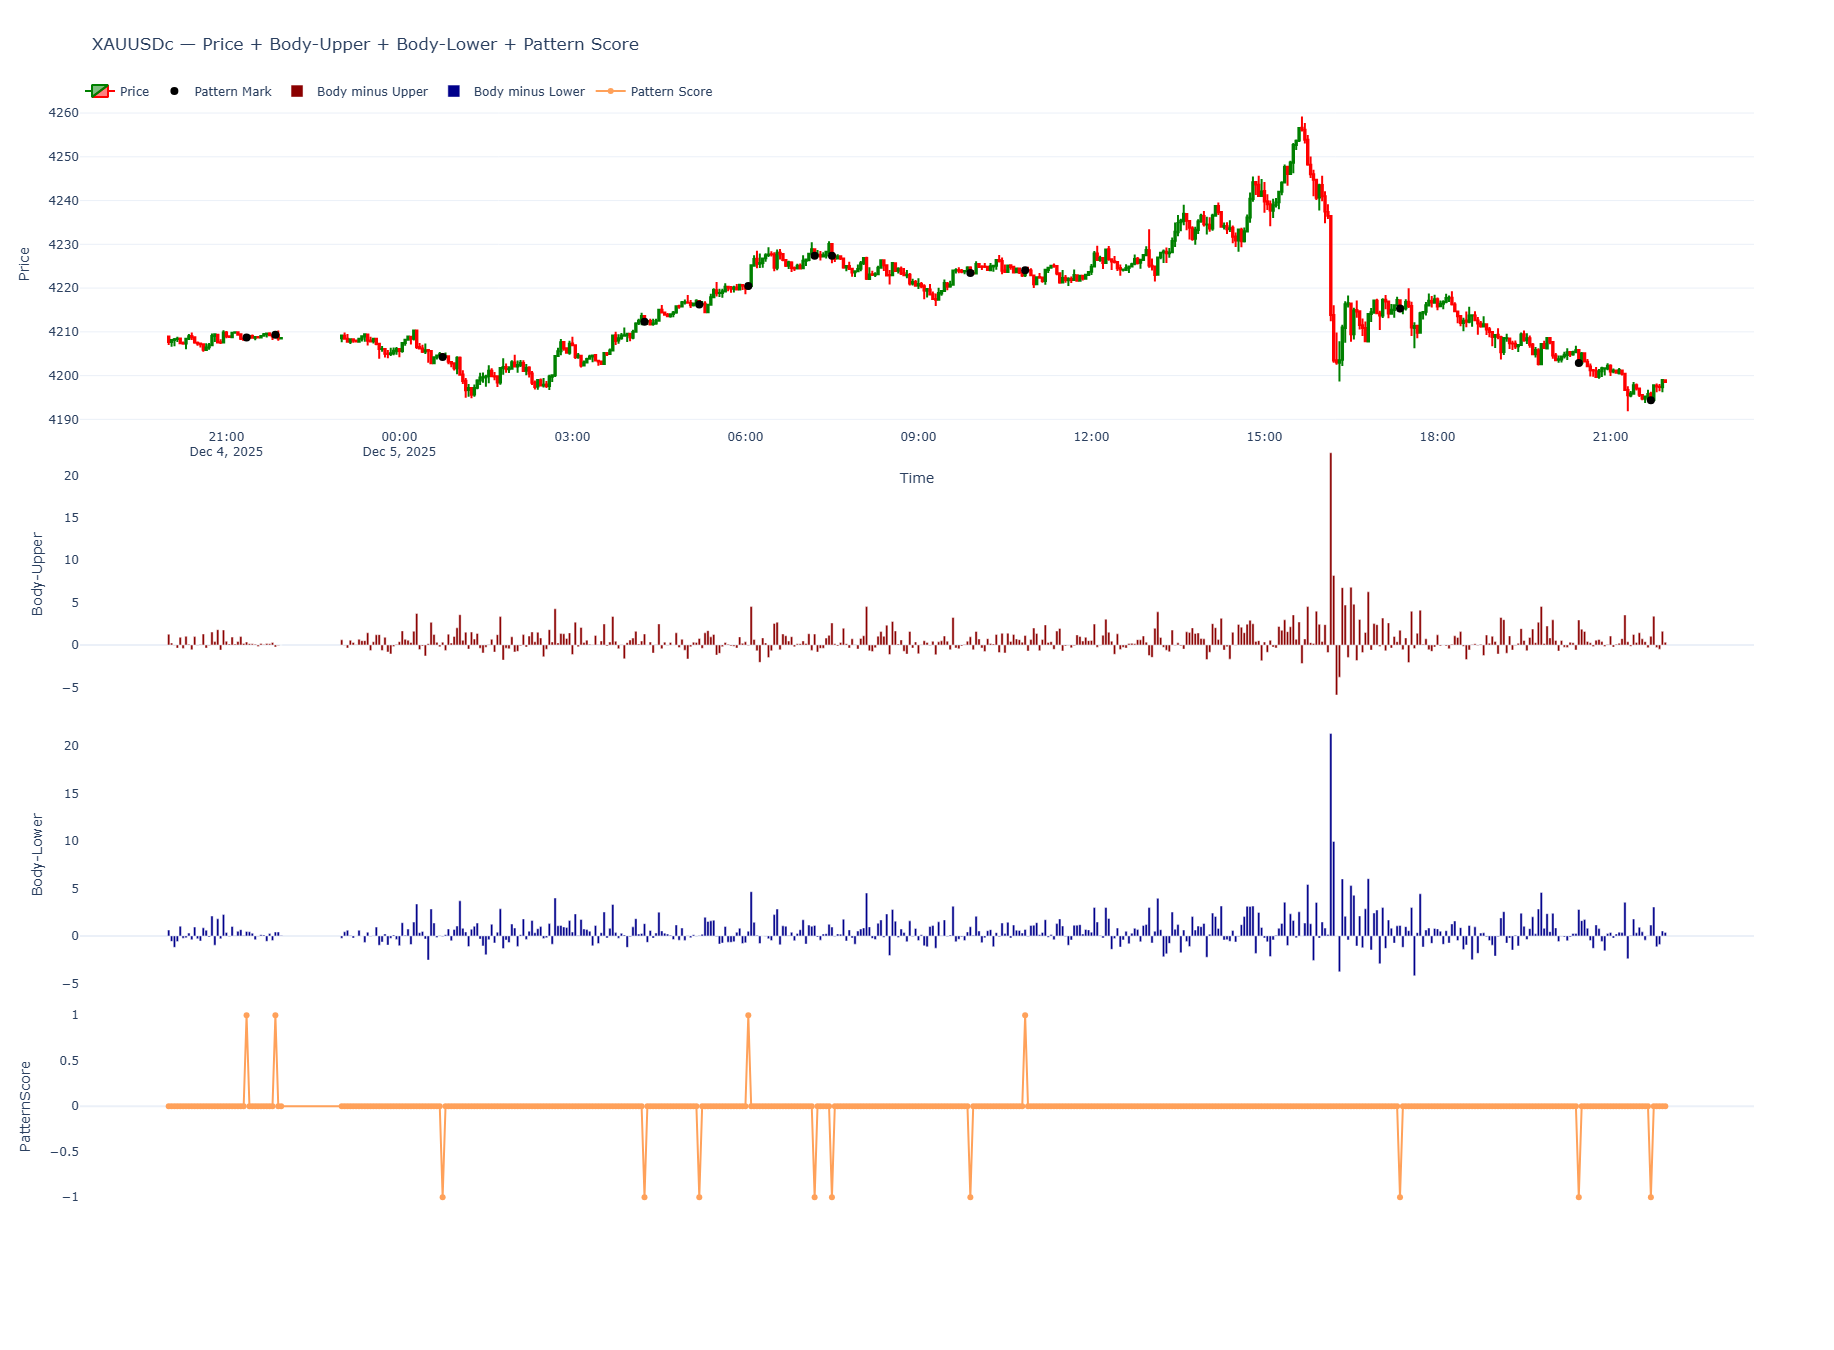

In [3]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df[df.index.dayofweek < 5]

df['body'] = abs(df['close'] - df['open'])
df['upper_wick'] = df['high'] - df[['open','close']].max(axis=1)
df['lower_wick'] = df[['open','close']].min(axis=1) - df['low']

df['body_minus_upper'] = df['body'] - df['upper_wick']
df['body_minus_lower'] = df['body'] - df['lower_wick']

pattern_score = []
pattern_mark = []

for i in range(len(df)):
    if i < 2:
        pattern_score.append(0)
        pattern_mark.append(np.nan)
        continue

    idx = [i, i-1, i-2]
    body_filter_pass = True
    for j in idx:
        cond_upper = df['body_minus_upper'].iloc[j] > 0
        cond_lower = df['body_minus_lower'].iloc[j] > 0
        if not (cond_upper or cond_lower):
            body_filter_pass = False
            break

    if not body_filter_pass:
        pattern_score.append(0)
        pattern_mark.append(np.nan)
        continue

    o0, h0, l0, c0 = df['open'].iloc[i], df['high'].iloc[i], df['low'].iloc[i], df['close'].iloc[i]
    o1, h1, l1, c1 = df['open'].iloc[i-1], df['high'].iloc[i-1], df['low'].iloc[i-1], df['close'].iloc[i-1]
    o2, h2, l2, c2 = df['open'].iloc[i-2], df['high'].iloc[i-2], df['low'].iloc[i-2], df['close'].iloc[i-2]

    curr_bearish = c0 < o0
    curr_bullish = c0 > o0

    prev_bullish = c1 > o1
    prev_bearish = c1 < o1

    prev2_bullish = c2 > o2
    prev2_bearish = c2 < o2

    score = 0
    mark = np.nan

    if curr_bearish and prev_bullish and prev2_bullish:
        if (c0 < o1) and (h1 > h2) and (h1 > h0):
            score = -1
            mark = c0

    if curr_bullish and prev_bearish and prev2_bearish:
        if (c0 > o1) and (l1 < l2) and (l1 < l0):
            score = 1
            mark = c0

    pattern_score.append(score)
    pattern_mark.append(mark)

df['pattern_score'] = pattern_score
df['pattern_mark'] = pattern_mark

fig = go.Figure()

fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='Price',
    increasing_line_color='green',
    decreasing_line_color='red'
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['pattern_mark'],
    mode='markers',
    marker=dict(size=8, color='black'),
    name='Pattern Mark'
))

fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_upper'],
    name='Body minus Upper',
    marker_color='darkred',
    yaxis='y2'
))

fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_lower'],
    name='Body minus Lower',
    marker_color='darkblue',
    yaxis='y3'
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['pattern_score'],
    mode='lines+markers',
    name='Pattern Score',
    marker=dict(size=6),
    yaxis='y4'
))

fig.update_layout(
    template='plotly_white',
    title='XAUUSDc — Price + Body-Upper + Body-Lower + Pattern Score',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price',         domain=[0.72, 1]),
    yaxis2=dict(title='Body-Upper',   domain=[0.48, 0.71], showgrid=False),
    yaxis3=dict(title='Body-Lower',   domain=[0.24, 0.47], showgrid=False),
    yaxis4=dict(title='PatternScore', domain=[0.05, 0.23], showgrid=False),

    legend=dict(orientation='h', y=1.02, x=0),
    height=1350
)

fig.show()


The '(Position 0, -1, and -2) candlesticks must have a corresponding must both body-upper and body-lower positive value, otherwise of body-upper 'and' or 'or' body-lower value is negative then don't mark the signal,

Three-panel layout
• Price
• Body-minus-upper
• Body-minus-lower

Pattern logic

New rule:
All (0, -1, -2) must have both body-minus-upper > 0 AND body-minus-lower > 0, otherwise no signal.

Pattern score pane + marker on price

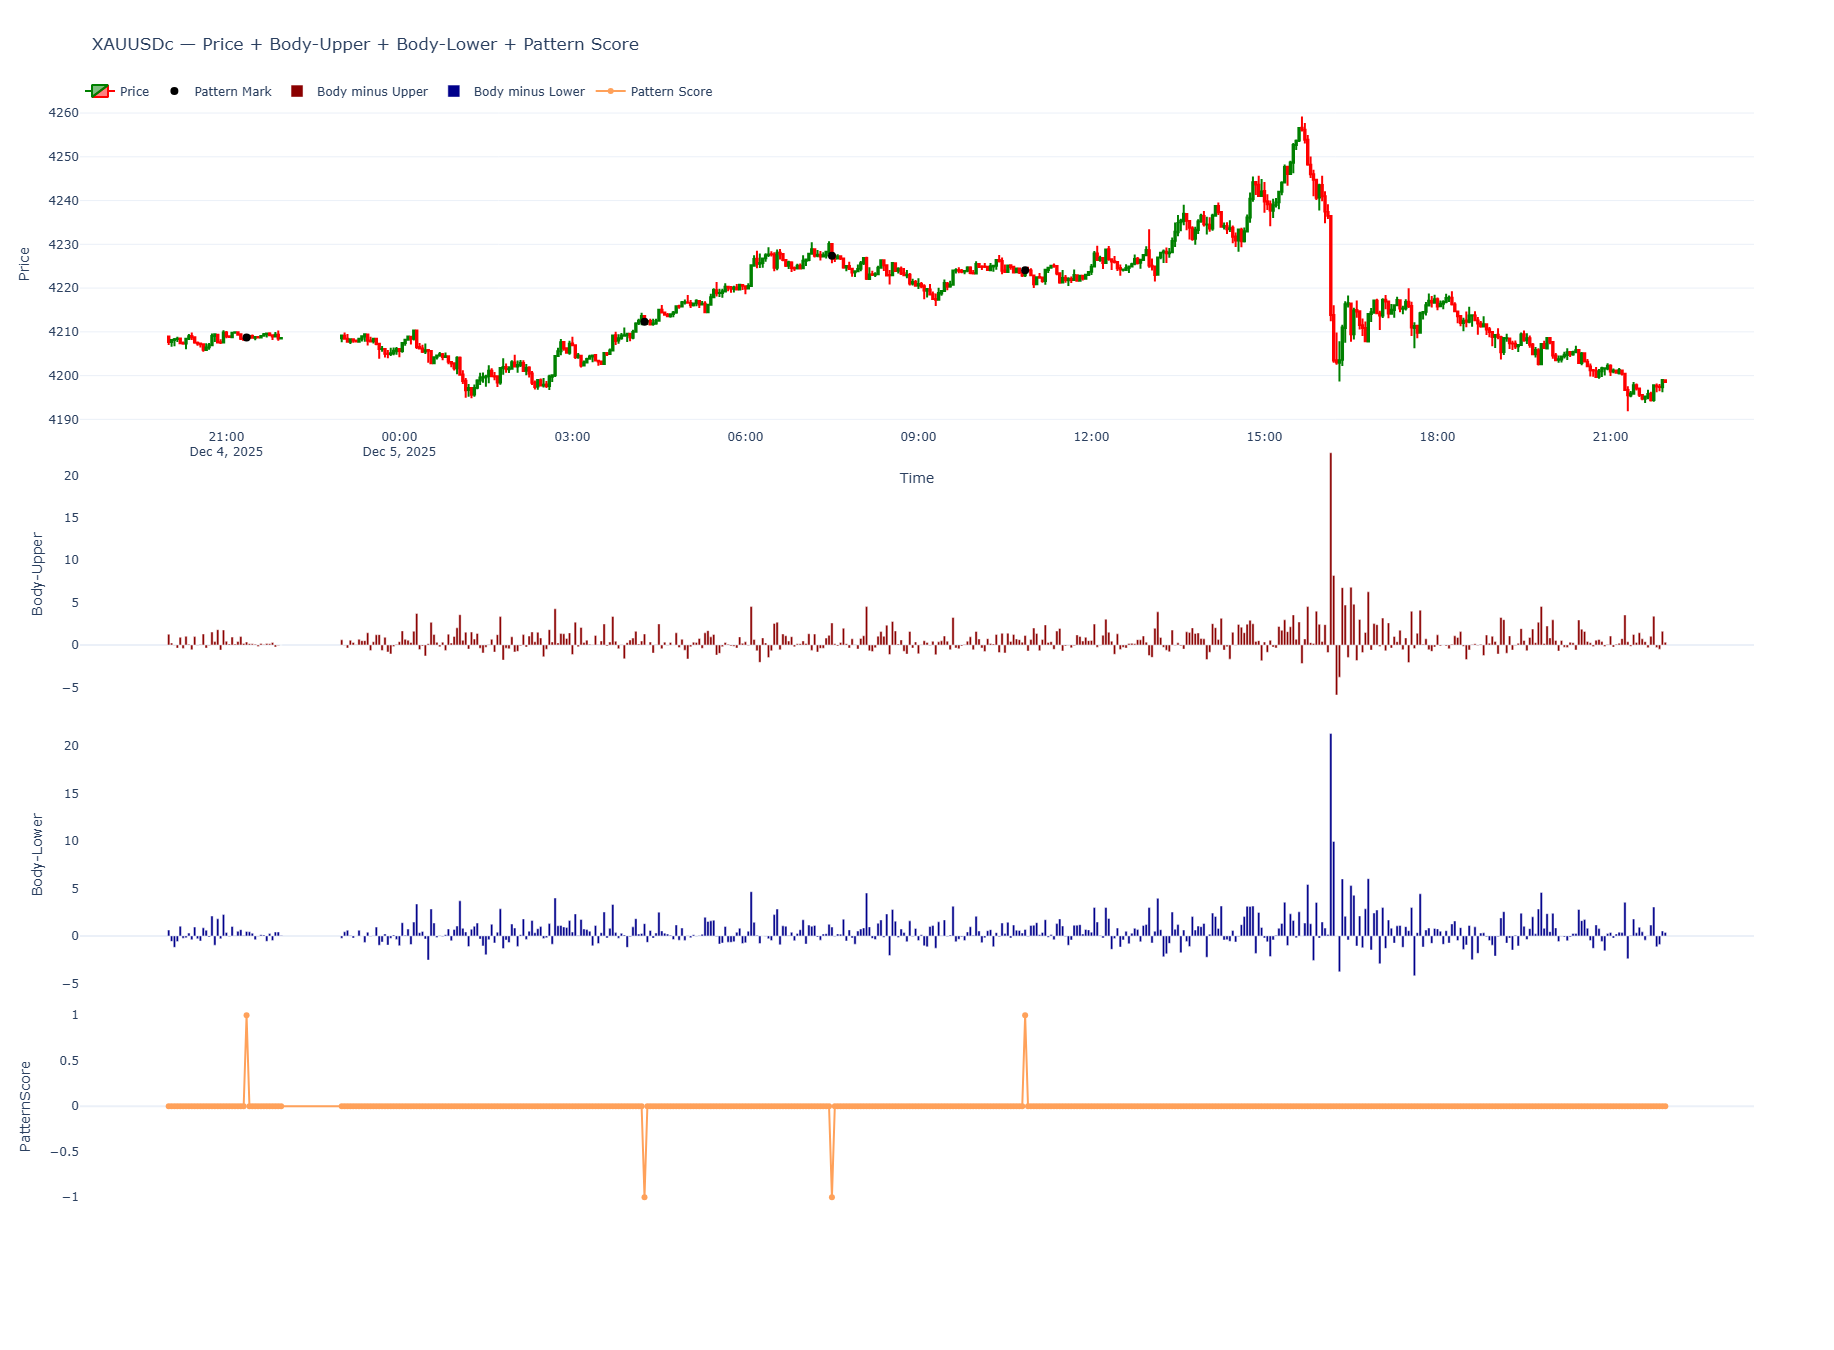

In [4]:
import MetaTrader5 as mt5 
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta

# -------------------------
# Initialize MT5
# -------------------------
if not mt5.initialize():
    print("MT5 initialization failed")
    mt5.shutdown()

# -------------------------
# Fetch 3-minute data
# -------------------------
symbol = "XAUUSDc"
timeframe = mt5.TIMEFRAME_M3
n_bars = 500
utc_from = datetime.now() - timedelta(days=5)

rates = mt5.copy_rates_from(symbol, timeframe, utc_from, n_bars)
mt5.shutdown()

# -------------------------
# Convert to DataFrame
# -------------------------
df = pd.DataFrame(rates)
df['time'] = pd.to_datetime(df['time'], unit='s')
df.set_index('time', inplace=True)
df = df[df.index.dayofweek < 5]

# -------------------------
# Calculations needed
# -------------------------
df['body'] = abs(df['close'] - df['open'])
df['upper_wick'] = df['high'] - df[['open','close']].max(axis=1)
df['lower_wick'] = df[['open','close']].min(axis=1) - df['low']

df['body_minus_upper'] = df['body'] - df['upper_wick']
df['body_minus_lower'] = df['body'] - df['lower_wick']

# -------------------------
# Pattern Score Logic with positive body-upper & body-lower requirement
# -------------------------
pattern_score = []
pattern_mark = []

for i in range(len(df)):
    if i < 2:
        pattern_score.append(0)
        pattern_mark.append(np.nan)
        continue

    i0 = i
    i1 = i - 1
    i2 = i - 2

    o0, h0, l0, c0 = df['open'].iloc[i0], df['high'].iloc[i0], df['low'].iloc[i0], df['close'].iloc[i0]
    o1, h1, l1, c1 = df['open'].iloc[i1], df['high'].iloc[i1], df['low'].iloc[i1], df['close'].iloc[i1]
    o2, h2, l2, c2 = df['open'].iloc[i2], df['high'].iloc[i2], df['low'].iloc[i2], df['close'].iloc[i2]

    # Required condition: body-upper and body-lower must ALL be positive for 0, -1, -2
    valid_bu_bl = (
        df['body_minus_upper'].iloc[i0] > 0 and df['body_minus_lower'].iloc[i0] > 0 and
        df['body_minus_upper'].iloc[i1] > 0 and df['body_minus_lower'].iloc[i1] > 0 and
        df['body_minus_upper'].iloc[i2] > 0 and df['body_minus_lower'].iloc[i2] > 0
    )

    if not valid_bu_bl:
        pattern_score.append(0)
        pattern_mark.append(np.nan)
        continue

    curr_bearish = c0 < o0
    curr_bullish = c0 > o0

    prev_bullish = c1 > o1
    prev_bearish = c1 < o1

    prev2_bullish = c2 > o2
    prev2_bearish = c2 < o2

    score = 0
    mark = np.nan

    # ---------------------------------------
    # Bearish Pattern
    # ---------------------------------------
    if curr_bearish and prev_bullish and prev2_bullish:
        if (c0 < o1) and (h1 > h2) and (h1 > h0):
            score = -1
            mark = c0

    # ---------------------------------------
    # Bullish Pattern
    # ---------------------------------------
    if curr_bullish and prev_bearish and prev2_bearish:
        if (c0 > o1) and (l1 < l2) and (l1 < l0):
            score = 1
            mark = c0

    pattern_score.append(score)
    pattern_mark.append(mark)

df['pattern_score'] = pattern_score
df['pattern_mark'] = pattern_mark

# -------------------------
# Plot: Price + Body-Upper + Body-Lower + Pattern Score
# -------------------------
fig = go.Figure()

# Pane 1 — Price
fig.add_trace(go.Candlestick(
    x=df.index,
    open=df['open'],
    high=df['high'],
    low=df['low'],
    close=df['close'],
    name='Price',
    increasing_line_color='green',
    decreasing_line_color='red'
))

# Pattern Markers
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['pattern_mark'],
    mode='markers',
    marker=dict(size=8, color='black'),
    name='Pattern Mark'
))

# Pane 2 — Body minus upper wick
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_upper'],
    name='Body minus Upper',
    marker_color='darkred',
    yaxis='y2'
))

# Pane 3 — Body minus lower wick
fig.add_trace(go.Bar(
    x=df.index,
    y=df['body_minus_lower'],
    name='Body minus Lower',
    marker_color='darkblue',
    yaxis='y3'
))

# Pane 4 — Pattern Score
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['pattern_score'],
    mode='lines+markers',
    name='Pattern Score',
    marker=dict(size=6),
    yaxis='y4'
))

# Layout
fig.update_layout(
    template='plotly_white',
    title='XAUUSDc — Price + Body-Upper + Body-Lower + Pattern Score',
    xaxis=dict(title='Time', rangeslider=dict(visible=False)),

    yaxis=dict(title='Price',         domain=[0.72, 1]),
    yaxis2=dict(title='Body-Upper',   domain=[0.48, 0.71], showgrid=False),
    yaxis3=dict(title='Body-Lower',   domain=[0.24, 0.47], showgrid=False),
    yaxis4=dict(title='PatternScore', domain=[0.05, 0.23], showgrid=False),

    legend=dict(orientation='h', y=1.02, x=0),
    height=1350
)

fig.show()
